Epoch 1/25
37/37 [==============================] - 13s 57ms/step - loss: 0.0116
Epoch 2/25
37/37 [==============================] - 2s 52ms/step - loss: 0.0019
Epoch 3/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0017
Epoch 4/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0018
Epoch 5/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0019
Epoch 6/25
37/37 [==============================] - 2s 59ms/step - loss: 0.0018
Epoch 7/25
37/37 [==============================] - 2s 60ms/step - loss: 0.0014
Epoch 8/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0016
Epoch 9/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0015
Epoch 10/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0015
Epoch 11/25
37/37 [==============================] - 2s 53ms/step - loss: 0.0014
Epoch 12/25
37/37 [==============================] - 2s 57ms/step - loss: 0.0013
Epoch 13/25
37/37 [=================

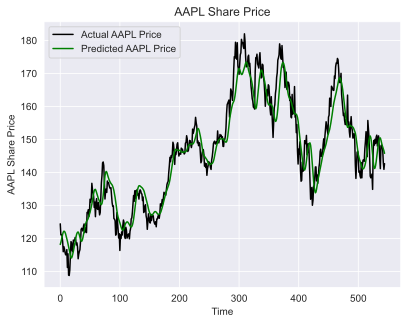

[[150.69999695]
 [154.47999573]
 [156.8999939 ]
 [153.72000122]
 [152.74000549]
 [150.42999268]
 [150.77000427]
 [151.75999451]
 [149.83999634]
 [142.47999573]
 [138.19999695]
 [142.44999695]
 [146.1000061 ]
 [146.3999939 ]
 [145.42999268]
 [140.08999634]
 [140.41999817]
 [138.97999573]
 [138.33999634]
 [142.99000549]
 [138.38000488]
 [142.41000366]
 [143.75      ]
 [143.86000061]
 [143.38999939]
 [147.27000427]
 [149.44999695]
 [152.33999634]
 [149.3500061 ]
 [144.80000305]
 [155.74000549]
 [153.33999634]
 [150.6499939 ]
 [145.02999878]
 [138.88000488]
 [138.38000488]
 [138.91999817]
 [139.5       ]
 [134.86999512]
 [146.86999512]
 [149.69999695]
 [148.27999878]
 [150.03999329]
 [148.78999329]
 [150.72000122]
 [151.28999329]
 [148.00999451]
 [150.17999268]
 [151.07000732]
 [148.11000061]
 [144.22000122]
 [141.16999817]
 [148.02999878]
 [148.30999756]
 [147.80999756]
 [146.63000488]
 [142.91000366]
 [140.94000244]
 [142.6499939 ]]
1/1 [==============================] - 4s 4s/step
 Pric

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import pandas_datareader as web
import datetime as dt

from matplotlib_inline.backend_inline import set_matplotlib_formats
from sklearn.preprocessing import MinMaxScaler
from keras.models import Sequential
from keras.layers import Dense, Dropout, LSTM
# this will allow our Matplotlib to save as a Vector
set_matplotlib_formats('svg')


# Load Data - Lets select the Company we are interested in
# tweak this how you want with any ticker. might work with Crypto
company = 'AAPL'

# Here we can specify, what timestamp we want to start our data from
# tweak this to however you want
start = dt.datetime(2015, 12, 12)
end = dt.datetime(2020, 10, 10)

# Now lets grab our data - we are asking for the Yahoo API
# select any API you want
data = web.DataReader(company, 'yahoo', start, end)

# Prepare data for the neural network
# we are going to scale down all the values we have so that they fit inbetween 0 and 1
scaler = MinMaxScaler(feature_range=(0, 1))

# we are NOT going to grab and transform the entire data
# we are only going to be interested in the closing price - we aren't predicting the open price/highs/lows etc.
# we can use 'AdjClose' to get data adjusted for splits - we don't care
scaled_data = scaler.fit_transform(data['Close'].values.reshape(-1, 1))

# now we are going to define how many days in the past we will look
# tweak this if you want
prediction_days = 60

#########################
# PREPARING TRAINING DATA
#########################

x_train = []
y_train = []

for x in range(prediction_days, len(scaled_data)):
    x_train.append(scaled_data[x - prediction_days:x, 0])
    y_train.append((scaled_data[x, 0]))

# turning x and y train into numpy arrays
x_train, y_train = np.array(x_train), np.array(y_train)

# now we are going to reshape the x_train so that it works with the neural network
# the 1 indicates one additional dimension
x_train = np.reshape(x_train, (x_train.shape[0], x_train.shape[1], 1))

##################
# BUILD THIS MODEL
##################
model = Sequential()

# now we can specify the layers - always add 1 LSTM layer and then a Dropout layer rinse/repeat the final layer is
# the Dense layer that is going to be just one unit, and it's going to the stock price prediction the 50 is just some
# number. change it and see what happens. maybe more or less layers = more fluid data more layers = longer time
# training - too much data can be bad return_sequence is True because an LSTM is a recurrent cell, so it's going to
# feedback the information, it is not going to feed forward the information like an ordinary Dense layer the input
model.add(LSTM(units=50, return_sequences=True, input_shape=(x_train.shape[1], 1)))
model.add(Dropout(0.2))
model.add(LSTM(units=50, return_sequences=True))
model.add(Dropout(0.2))
model.add(LSTM(units=50))
model.add(Dropout(0.2))
# prediction of the next closing price
model.add(Dense(units=1))

# math is not that exciting, don't worry about these
# if interested, google them
model.compile(optimizer='adam', loss='mean_squared_error')

# epochs are saying the model will see the SAME data 24 times (Indexing woes)
# batch_size is saying the model is going to see 32 units at once, ALL THE TIME
# tweak these if you want
model.fit(x_train, y_train, epochs=25, batch_size=32)

# we can save this if we want with model.save and load it with keras
# we aren't doing that here tho, we want to immediately use it

##################################################################
# TEST THE MODEL ACCURACY ON EXISTING DATA - what is the accuracy?
##################################################################

# LOAD THE DATA - it has to be data the model has not seen before
# this is the time range of the data - we have the data but the model has never seen that data
# so this is a perfect way to see how well it performs
# up above we said we wanted data up until Oct 10, 2022, so we will start now and look back
# Tweak the start date if you want
test_start = dt.datetime(2020, 10, 10)
test_end = dt.datetime.now()
test_data = web.DataReader(company,  'yahoo', test_start, test_end)

# what we will do with that data is get the prices,
# we need to scale prices, we need to concatenate the full data set that we want to predict on
# this is NOT the predicted price, but the real price from the market
actual_prices = test_data['Close'].values

# this will combine the training data and the test data
total_dataset = pd.concat((data['Close'], test_data['Close']), axis=0)

# this is what our model is going to see as an input, so it can predict
model_inputs = total_dataset[len(total_dataset) - len(test_data) - prediction_days:].values
model_inputs = model_inputs.reshape(-1, 1)
model_inputs = scaler.transform(model_inputs)

###############################
# MAKE PREDICTIONS ON TEST DATA
###############################

# we don't use the y_test because we already have the stock prices
x_test = []

# if you remove the + 1 it will remove the newest data
for x in range(prediction_days, len(model_inputs)):
    x_test.append(model_inputs[x - prediction_days:x, 0])

x_test = np.array(x_test)
x_test = np.reshape(x_test, (x_test.shape[0], x_test.shape[1], 1))

# now let's predict on the x_test data what you need to keep in the mind, that the predicted prices now going to be
# scaled, so we need to reverse scale them or rather inverse_transform them
predicted_prices = model.predict(x_test)
# now we are back to the actual predicted price, non-scaled
predicted_prices = scaler.inverse_transform(predicted_prices)

# now let plot the predictions instead of just numbers. CHARTS BABY
plt.plot(actual_prices, color="black", label=f"Actual {company} Price")
plt.plot(predicted_prices, color="green", label=f"Predicted {company} Price")
plt.title(f"{company} Share Price")
plt.xlabel("Time")
plt.ylabel(f"{company} Share Price")
plt.legend()
# you can also do .pdf for a vector like file (super zoomy)
plt.savefig('Prediction_test.svg')
# this acts as a 'end conn' situation
plt.show()

#########################
# PREDICTING OUR NEXT DAY
#########################

real_data = [model_inputs[len(model_inputs) + 1 - prediction_days:len(model_inputs + 1), 0]]
real_data = np.array(real_data)
real_data = np.reshape(real_data, (real_data.shape[0], real_data.shape[1], 1))

print(scaler.inverse_transform(real_data[-1]))

prediction = model.predict(real_data)
prediction = scaler.inverse_transform(prediction)
print(f' PricePrediction for tomorrow: {prediction}')

In [4]:
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error
#evaluate the model
mae = mean_absolute_error(actual_prices, predicted_prices)
mse = mean_squared_error(actual_prices, predicted_prices)
rmse = np.sqrt(mse)
r2 = r2_score(actual_prices, predicted_prices)

#printing the model evaluation values
print('mae:  {:.2f}'.format(mae))
print('mse:  {:.2f}'.format(mse))
print('Root mean square error:  {:.2f}'.format(rmse))
print('R2 score: ', r2)


mae:  3.95
mse:  26.13
Root mean square error:  5.11
R2 score:  0.9100017118767705
